In [ ]:
!pip install transformers

In [ ]:
# !pip install xformers

In [ ]:
!pip install beautifulsoup4

In [ ]:
!pip install sentence-transformers

In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import nltk
import re
import torch
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('news-merged-aug.csv')
data.head()

# Extract the text
texts = data["title"].tolist()
# print(texts)
# type(data["description"])

In [ ]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Preprocess data
for index, row in data.iterrows():
    try:
        title = row['title']
        soup = BeautifulSoup(title, 'html.parser')
        cleaned_title = soup.get_text()
        data.at[index, 'title'] = cleaned_title

        description = row['description']
        soup = BeautifulSoup(description, 'html.parser')
        cleaned_description = soup.get_text()
        data.at[index, 'description'] = cleaned_description
    except:
        pass


<ipython-input-51-e156dd784c8d>:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(description, 'html.parser')
<ipython-input-51-e156dd784c8d>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(title, 'html.parser')


In [ ]:
from transformers import pipeline

classification_pipe = pipeline("text-classification", model="qanastek/51-languages-classifier")

In [ ]:
results = []

# Process each text using the pipeline
for text in texts:
    result = classification_pipe(text)
    results.append(result)

# Extract labels and scores from the results
labels = [result[0]['label'] for result in results]
scores = [result[0]['score'] for result in results]

# Add labels and scores to the original DataFrame
data['predicted_label'] = labels
data['confidence_score'] = scores

In [ ]:
# #Display the result
# print(data.head)

In [ ]:
# Get distinct predicted labels
distinct_labels = data['predicted_label'].unique()
print(distinct_labels)

['en-US' 'fr-FR' 'ja-JP' 'es-ES' 'de-DE' 'vi-VN' 'id-ID' 'ms-MY' 'jv-ID'
 'nl-NL' 'pt-PT' 'ar-SA' 'am-ET' 'it-IT' 'ro-RO' 'sl-SL' 'th-TH' 'km-KH']


In [ ]:
language_dataframes = {}

for label in distinct_labels:
    # Filter data based on the predicted label
    label_data = data[data['predicted_label'] == label]

    # Create a new DataFrame for the label-specific data
    label_dataframe = pd.DataFrame(label_data)

    # Store the filtered data in the dictionary with label as key
    language_dataframes[label] = label_dataframe

# Access individual dataframes using the label as key
for label, label_dataframe in language_dataframes.items():
    print(f"Language: {label}")
    print(label_dataframe)
    print("------------------")

Language: en-US
                            source.id          source.name  \
0                                 NaN         The Guardian   
1                                 NaN  Yahoo Entertainment   
2                                 NaN         The Guardian   
3                  al-jazeera-english   Al Jazeera English   
4                  al-jazeera-english   Al Jazeera English   
..                                ...                  ...   
580  a8e99ee05907be49fd31ea240a337857      technobaboy.com   
581  cddd8077001b47ece4e4afbcaf50229f   chiangraitimes.com   
582  9aab6546de29d9d85f6cb6f56da35fcf      orissadiary.com   
583  97adda131dacf742d4283edd331ff01e     tellerreport.com   
585  9c451113c2481b5a5add785724c515e3            yahoo.com   

                                     author  \
0    Amy Hawkins Senior China correspondent   
1                                   Reuters   
2            Emma Graham-Harrison in Taipei   
3                                Al Jazeera   
4   

In [ ]:
!pip install stopwordsiso

In [ ]:
import stopwordsiso as stopwords

def clean_text(text, lang_label):
    # lang_label = data['predicted_label']


    if lang_label == 'en-US' or lang_label == 'am-ET' or lang_label == 'km-KH':
        stop_words = set(stopwords.stopwords('en'))
    elif lang_label == 'fr-FR':
        stop_words = set(stopwords.stopwords('fr'))
    elif lang_label == 'ja-JP':
        stop_words = set(stopwords.stopwords('jp'))
    elif lang_label == 'es-ES':
        stop_words = set(stopwords.stopwords('es'))
    elif lang_label == 'de-DE':
        stop_words = set(stopwords.stopwords('de'))
    elif lang_label == 'vi-VN':
        stop_words = set(stopwords.stopwords('vi'))
    elif lang_label == 'id-ID':
        stop_words = set(stopwords.stopwords('id'))
    elif lang_label == 'ms-MY':
        stop_words = set(stopwords.stopwords('ms'))
    elif lang_label == 'jv-ID':
        stop_words = set(stopwords.stopwords('id'))
    elif lang_label == 'nl-NL':
        stop_words = set(stopwords.stopwords('nl'))
    elif lang_label == 'pt-PT':
        stop_words = set(stopwords.stopwords('pt'))
    elif lang_label == 'ar-SA':
        stop_words = set(stopwords.stopwords('ar'))
    elif lang_label == 'it-IT':
        stop_words = set(stopwords.stopwords('it'))
    elif lang_label == 'ro-RO':
        stop_words = set(stopwords.stopwords('ro'))
    elif lang_label == 'sl-SL':
        stop_words = set(stopwords.stopwords('sl'))
    elif lang_label == 'th-TH':
        stop_words = set(stopwords.stopwords('th'))
    else:
        raise ValueError(f"Unsupported language: {lang_label}")

    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.lower().split()  # Convert to lowercase and split into words
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    cleaned_text = ' '.join(words)
    return cleaned_text

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the desired sentence transformer model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Initialize an empty array to store the embeddings
all_embeddings = []

# Iterate through the DataFrame rows
for index, row in data.iterrows():
    lang_label = row['predicted_label']
    title = row['title']
    description = row['description']

    # Make sure the description is a string
    if not isinstance(description, str):
        description = str(description)

    cleaned_title = clean_text(title, lang_label)
    cleaned_description = clean_text(description, lang_label)

    # Generate embeddings for the cleaned title and description
    title_embedding = model.encode(cleaned_title)
    description_embedding = model.encode(cleaned_description)

 # Concatenate embeddings
    combined_embedding = np.concatenate((title_embedding, description_embedding))
    all_embeddings.append(combined_embedding)


## Use TruncatedSVD to reduce dimensionality of the concatenated embeddings.

In [ ]:
feature_matrix = np.array(all_embeddings)
print("Feature matrix shape:", feature_matrix.shape)

Feature matrix shape: (586, 768)


In [ ]:
# Number of dimensions to reduce to
n_components = 100

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=n_components)

# Apply TruncatedSVD to the feature matrix
reduced_embeddings = svd.fit_transform(feature_matrix)

# The reduced_embeddings matrix now contains the reduced-dimensional embeddings
print("Original shape:", feature_matrix.shape)
print("Reduced shape:", reduced_embeddings.shape)

Original shape: (586, 768)
Reduced shape: (586, 100)


## Cluster using KMeans on the dimensionality reduced embeddings.

In [ ]:
# Cluster using KMeans
n_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualize using t-SNE and plot clusters, coloring by cluster label.

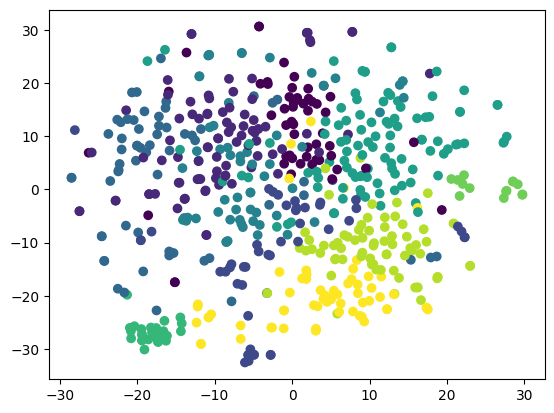

In [ ]:
# Visualize using t-SNE
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(reduced_embeddings)

# Plot clusters using matplotlib
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_labels)
plt.show()